In [110]:
# Load libraries
import numpy
from numpy import arange
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [65]:
# Load full dataset
filename = 'ssdata_for_train_common.txt'
dataset_full = read_csv(filename, sep='\t')
dataset_full.shape

(1257780, 87)

In [66]:
# Select features to be used to build model
cols = ["Site.Type","TA.raw","SPS.raw","sRNA1A.scaled","sRNA1C.scaled","sRNA1G.scaled","sRNA8A.scaled","sRNA8C.scaled","sRNA8G.scaled","site8A.scaled","site8C.scaled","site8G.scaled","local.AU.raw","X3..pairing.raw","SA.raw","Min_dist.raw","PCT.raw","ORF.length.raw","X3.UTR.length.raw","Offset.6mer.raw","ORF.8mer.raw","transfection_final_conc_curated","trans_reagent","genetic_background","hours","GPL","Series","cell","log2fc"]
dataset = dataset_full[cols]
dataset.shape

(1257780, 29)

In [67]:
dataset.head()

,Site.Type,TA.raw,SPS.raw,sRNA1A.scaled,sRNA1C.scaled,sRNA1G.scaled,sRNA8A.scaled,sRNA8C.scaled,sRNA8G.scaled,site8A.scaled,...,Offset.6mer.raw,ORF.8mer.raw,transfection_final_conc_curated,trans_reagent,genetic_background,hours,GPL,Series,cell,log2fc
0,7mer-m8,3.70,-8.80,0,0,0,0,0,1,0,...,1,0,2.50e-08,Lipofectamine2000,wildtype,8.0,GPL570,GSE27431,HEY,1.68e-01
1,7mer-1a,3.62,-6.43,0,0,0,0,1,0,0,...,0,0,2.50e-08,Lipofectamine2000,wildtype,8.0,GPL570,GSE27431,HEY,3.53e-01
2,6mer,3.54,-5.66,0,0,0,0,0,0,0,...,0,0,5.00e-08,HiPerFect,wildtype,7.0,GPL4133,GSE28522,HeLa,2.75e-01
3,6mer,3.54,-5.66,0,0,0,0,0,0,0,...,0,0,5.00e-08,HiPerFect,wildtype,7.0,GPL4133,GSE28522,TW01,-2.33e-02
4,6mer,3.57,-3.58,0,0,0,1,0,0,0,...,1,0,NaN,HiPerFect,wildtype,11.0,GPL13607,GSE29207,hMADS,9.55e-03


In [69]:
# Summarize Data

# shape
print(dataset.shape)
# types
print(dataset.dtypes)

(1257780, 29)
Site.Type                           object
TA.raw                             float64
SPS.raw                            float64
sRNA1A.scaled                        int64
sRNA1C.scaled                        int64
sRNA1G.scaled                        int64
sRNA8A.scaled                        int64
sRNA8C.scaled                        int64
sRNA8G.scaled                        int64
site8A.scaled                        int64
site8C.scaled                        int64
site8G.scaled                        int64
local.AU.raw                       float64
X3..pairing.raw                    float64
SA.raw                             float64
Min_dist.raw                       float64
PCT.raw                            float64
ORF.length.raw                     float64
X3.UTR.length.raw                  float64
Offset.6mer.raw                      int64
ORF.8mer.raw                         int64
transfection_final_conc_curated    float64
trans_reagent                       obje

### Preprocess Categorical Data

In [81]:
# Show classes in the features in object type, which must be transformed into digits.

cols = ['Site.Type', "trans_reagent","genetic_background","GPL","Series","cell",]
for i, v in enumerate(cols):
    print dataset.groupby(v).size()
    print 

Site.Type
6mer       663452
7mer-1a    230616
7mer-m8    265919
8mer-1a     97793
dtype: int64

trans_reagent
Amaxa nucleofection             7284
Cell Line Nucleofector kit     30919
DharmaFECT                     22992
DharmaFECT3                     8502
HiPerFect                      66767
INTERFERin                      2575
Lentiviral vector              72953
Lipofectamin RNAi MAX         406776
Lipofectamine2000             378591
MicroPorator MP-100             2528
Neon transfection System        3642
Oligofectamine                 20673
PureFection                     6704
Retroviral vector              13148
SilentFect                     28828
Viral vector                    3042
X-tremeGENE siRNA               3857
siPORT neo-FX                  32412
dtype: int64

genetic_background
Dicer        119591
wildtype    1138189
dtype: int64

GPL
GPL10332    128884
GPL10558    127171
GPL10739      2972
GPL10904      7124
GPL13158      7466
GPL13497      8884
GPL13607    110402


In [111]:
mlb1 = LabelEncoder()
mlb1.fit(dataset['Site.Type'])
hot_SiteType = mlb1.transform(dataset['Site.Type'])
print "Number of classes: " + str(len(mlb1.classes_))
print mlb1.classes_

Number of classes: 4
['6mer' '7mer-1a' '7mer-m8' '8mer-1a']


In [129]:
mlb2 = LabelEncoder()
mlb2.fit(dataset['trans_reagent'])
hot_trans_reagent = mlb2.fit_transform(dataset['trans_reagent'])
print "Number of classes: " + str(len(mlb2.classes_))
print mlb2.classes_

Number of classes: 19
[nan 'Amaxa nucleofection' 'Cell Line Nucleofector kit' 'DharmaFECT'
 'DharmaFECT3' 'HiPerFect' 'INTERFERin' 'Lentiviral vector'
 'Lipofectamin RNAi MAX' 'Lipofectamine2000' 'MicroPorator MP-100'
 'Neon transfection System' 'Oligofectamine' 'PureFection'
 'Retroviral vector' 'SilentFect' 'Viral vector' 'X-tremeGENE siRNA'
 'siPORT neo-FX']


In [115]:
mlb3 = LabelEncoder()
mlb3.fit(dataset['genetic_background'])
hot_genetic_background = mlb3.transform(dataset['genetic_background'])
print "Number of classes: " + str(len(mlb3.classes_))
print mlb3.classes_

Number of classes: 2
['Dicer' 'wildtype']


In [116]:
mlb4 = LabelEncoder()
mlb4.fit(dataset['GPL'])
hot_GPL = mlb4.transform(dataset['GPL'])
print "Number of classes: " + str(len(mlb4.classes_))
print mlb4.classes_

Number of classes: 44
['GPL10332' 'GPL10558' 'GPL10739' 'GPL10904' 'GPL13158' 'GPL13497'
 'GPL13607' 'GPL13915' 'GPL14550' 'GPL1456' 'GPL15207' 'GPL15338'
 'GPL15496' 'GPL16359' 'GPL16699' 'GPL1708' 'GPL1749' 'GPL19383' 'GPL3991'
 'GPL4133' 'GPL4372' 'GPL4925' 'GPL5104' 'GPL5175' 'GPL5639' 'GPL570'
 'GPL571' 'GPL5799' 'GPL6098' 'GPL6102' 'GPL6104' 'GPL6171' 'GPL6244'
 'GPL6480' 'GPL6793' 'GPL6848' 'GPL6879' 'GPL6883' 'GPL6884' 'GPL6947'
 'GPL7038' 'GPL7504' 'GPL8755' 'GPL885']


In [117]:
mlb5 = LabelEncoder()
mlb5.fit(dataset['Series'])
hot_Series = mlb5.transform(dataset['Series'])
print "Number of classes: " + str(len(mlb5.classes_))
print mlb5.classes_

Number of classes: 176
['GSE10057' 'GSE10455' 'GSE10864' 'GSE11701' 'GSE11778' 'GSE12100'
 'GSE12278' 'GSE12615' 'GSE13105' 'GSE13286' 'GSE13674' 'GSE14477'
 'GSE14507' 'GSE14537' 'GSE14831' 'GSE14847' 'GSE15281' 'GSE16239'
 'GSE16568' 'GSE16571' 'GSE16674' 'GSE16700' 'GSE16988' 'GSE17460'
 'GSE17508' 'GSE17828' 'GSE18510' 'GSE18545' 'GSE18625' 'GSE18695'
 'GSE18713' 'GSE19680' 'GSE19688' 'GSE19717' 'GSE19718' 'GSE19737'
 'GSE19931' 'GSE19933' 'GSE20028' 'GSE20293' 'GSE20637' 'GSE20745'
 'GSE2075' 'GSE21458' 'GSE21832' 'GSE22002' 'GSE22143' 'GSE23019'
 'GSE24613' 'GSE24782' 'GSE24812' 'GSE24980' 'GSE25162' 'GSE25215'
 'GSE25332' 'GSE26032' 'GSE26332' 'GSE26545' 'GSE26996' 'GSE27431'
 'GSE27718' 'GSE28400' 'GSE28456' 'GSE28522' 'GSE28810' 'GSE29043'
 'GSE29207' 'GSE29760' 'GSE31277' 'GSE31397' 'GSE31566' 'GSE31620'
 'GSE31751' 'GSE32617' 'GSE32876' 'GSE32999' 'GSE33247' 'GSE33293'
 'GSE33420' 'GSE33672' 'GSE33952' 'GSE34242' 'GSE34482' 'GSE34815'
 'GSE34846' 'GSE34893' 'GSE35030' 'GSE35

In [119]:
mlb6 = LabelEncoder()
mlb6.fit(dataset['cell'])
hot_cell = mlb6.transform(dataset['cell'])
print "Number of classes: " + str(len(mlb6.classes_))
print mlb6.classes_

Number of classes: 126
['2091' '218TGpp' '4L' '5B1' '786O' 'A172' 'A498' 'A549' 'AGS' 'Akata'
 'BG1' 'BM-MSC' 'BOY' 'BT549' 'C4-2' 'C8161' 'CB-HSPC' 'Calu-3' 'DLD1'
 'DU145' 'EC109' 'ES2' 'FLF' 'FaDu' 'GIST-T1' 'H1299' 'H157' 'H3255' 'H4'
 'H441' 'H929' 'HAEC' 'HCE' 'HCT116' 'HEK293' 'HEY' 'HFL1' 'HSC3' 'HSF2'
 'HSPC' 'HTM' 'HUVEC' 'HaCaT' 'HeLa' 'Hec50' 'HepG2' 'Hs683' 'Huh7'
 'Human neonatal dermal fibroblasts cell' 'IMC3' 'Jurkat' 'K562' 'KATOIII'
 'KK47' 'KYSE170' 'KYSE520' 'LNCaP' 'LSMC' 'MCF10A' 'MCF7' 'MCFDCIS'
 'MDAMB231' 'MDDC' 'MHHES1' 'MIAPaCa2' 'MKN45' 'MKN7' 'MKN74' 'MM1R'
 'MSK543' 'MSMC' 'Malme3M' 'MeWo' 'My-La' 'NESCs' 'NTERT1' 'Namalwa' 'OE33'
 'OVCA' 'OVSAYO' 'P3HR1' 'PANC-1' 'PC10' 'PC3' 'PEO1' 'PEO4' 'PNET' 'RD'
 'RPE1' 'Raji' 'Ramos' 'SAS' 'SCC25' 'SGBS' 'SHSY5Y' 'SK-LC-7' 'SKBr3'
 'SKMEL28' 'SKMel147' 'SKNBE2' 'SKNSH' 'SKOV3' 'SNB19' 'SW1783' 'SW780'
 'T.Tn' 'T24' 'TCP1' 'TE13' 'TE2' 'TOV21G' 'TS543' 'TW01' 'U251' 'U2OS'
 'U87MG' 'UMUC3' 'WERI' 'WM1552C' 'caki1' '

In [132]:
print hot_SiteType.shape
print hot_trans_reagent.shape
print hot_genetic_background.shape
print hot_GPL.shape
print hot_Series.shape
print hot_cell.shape

(1257780,)
(1257780,)
(1257780,)
(1257780,)
(1257780,)
(1257780,)


In [133]:
print hot_SiteType
print hot_trans_reagent
print hot_genetic_background
print hot_GPL
print hot_Series
print hot_cell

[2 1 0 ..., 0 0 0]
[9 9 5 ..., 8 9 9]
[1 1 1 ..., 1 1 1]
[25 25 19 ...,  0 36 36]
[59 59 63 ..., 55 57 57]
[ 35  35  43 ...,  83  94 100]


In [139]:
# Substitute Categorical valuable with digits
dataset['Site.Type'] = hot_SiteType
dataset['trans_reagent'] = hot_trans_reagent
dataset['genetic_background'] = hot_genetic_background
dataset['GPL'] = hot_GPL
dataset['Series'] = hot_Series
dataset['cell'] = hot_cell

/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

### Deal with NaN

In [140]:
# check if NA exists in each column
dataset.isnull().any(axis=0)

Site.Type                          False
TA.raw                             False
SPS.raw                            False
sRNA1A.scaled                      False
sRNA1C.scaled                      False
sRNA1G.scaled                      False
sRNA8A.scaled                      False
sRNA8C.scaled                      False
sRNA8G.scaled                      False
site8A.scaled                      False
site8C.scaled                      False
site8G.scaled                      False
local.AU.raw                       False
X3..pairing.raw                    False
SA.raw                             False
Min_dist.raw                       False
PCT.raw                             True
ORF.length.raw                     False
X3.UTR.length.raw                  False
Offset.6mer.raw                    False
ORF.8mer.raw                       False
transfection_final_conc_curated     True
trans_reagent                      False
genetic_background                 False
hours           

In [141]:
# count NA samples
dataset.isnull().sum()

Site.Type                               0
TA.raw                                  0
SPS.raw                                 0
sRNA1A.scaled                           0
sRNA1C.scaled                           0
sRNA1G.scaled                           0
sRNA8A.scaled                           0
sRNA8C.scaled                           0
sRNA8G.scaled                           0
site8A.scaled                           0
site8C.scaled                           0
site8G.scaled                           0
local.AU.raw                            0
X3..pairing.raw                         0
SA.raw                                  0
Min_dist.raw                            0
PCT.raw                            239268
ORF.length.raw                          0
X3.UTR.length.raw                       0
Offset.6mer.raw                         0
ORF.8mer.raw                            0
transfection_final_conc_curated    361102
trans_reagent                           0
genetic_background                

In [135]:
dataset.head()

,Site.Type,TA.raw,SPS.raw,sRNA1A.scaled,sRNA1C.scaled,sRNA1G.scaled,sRNA8A.scaled,sRNA8C.scaled,sRNA8G.scaled,site8A.scaled,...,Offset.6mer.raw,ORF.8mer.raw,transfection_final_conc_curated,trans_reagent,genetic_background,hours,GPL,Series,cell,log2fc
0,2,3.70,-8.80,0,0,0,0,0,1,0,...,1,0,2.50e-08,9,1,8.0,25,59,35,1.68e-01
1,1,3.62,-6.43,0,0,0,0,1,0,0,...,0,0,2.50e-08,9,1,8.0,25,59,35,3.53e-01
2,0,3.54,-5.66,0,0,0,0,0,0,0,...,0,0,5.00e-08,5,1,7.0,19,63,43,2.75e-01
3,0,3.54,-5.66,0,0,0,0,0,0,0,...,0,0,5.00e-08,5,1,7.0,19,63,112,-2.33e-02
4,0,3.57,-3.58,0,0,0,1,0,0,0,...,1,0,NaN,5,1,11.0,6,66,121,9.55e-03


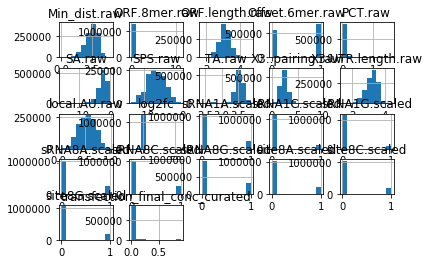

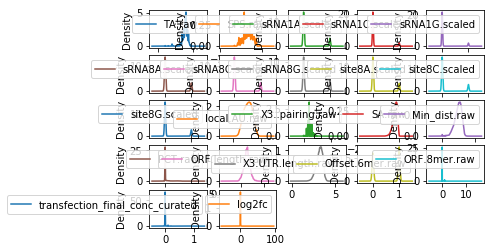

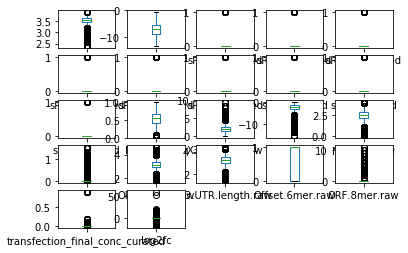

KeyboardInterrupt: 

In [6]:
# Data visualizations

# histograms
dataset.hist()
pyplot.show()
# density
dataset.plot(kind='density', subplots=True, layout=(5,5), sharex=False)
pyplot.show()
# box and whisker plots
dataset.plot(kind='box', subplots=True, layout=(5,5), sharex=False, sharey=False)
pyplot.show()

# scatter plot matrix
scatter_matrix(dataset)
pyplot.show()
# correlation matrix
fig = pyplot.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(dataset.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cax)
ticks = arange(0,14,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
pyplot.show()

In [144]:
# Prepare Data

# Split-out validation dataset
array = dataset.values
X = array[:,0:28]
Y = array[:,28]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)


In [138]:
# Evaluate Algorithms
# Test options and evaluation metric
num_folds = 5
seed = 7
scoring = 'neg_mean_squared_error'

# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = KFold(n_splits=num_folds, random_state=seed)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))
results = []
names = []
for name, model in pipelines:
	kfold = KFold(n_splits=num_folds, random_state=seed)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [ ]:
# KNN Algorithm tuning
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
k_values = numpy.array([1,3,5,7,9,11,13,15,17,19,21])
param_grid = dict(n_neighbors=k_values)
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



In [ ]:
# ensembles
ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor())])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor())])))
results = []
names = []
for name, model in ensembles:
	kfold = KFold(n_splits=num_folds, random_state=seed)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [ ]:
# Tune scaled GBM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=numpy.array([50,100,150,200,250,300,350,400]))
model = GradientBoostingRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Make predictions on validation dataset

# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = GradientBoostingRegressor(random_state=seed, n_estimators=400)
model.fit(rescaledX, Y_train)
# transform the validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print(mean_squared_error(Y_validation, predictions))